# Tutorial: Basics of Iterative Inference Programming in Gen

This tutorial introduces the basics of inference programming in Gen.
In particular, in this notebook we'll focus on _iterative_
inference programs, which include Markov chain Monte Carlo algorithms.

## The task: curve-fitting with outliers

Suppose we have a dataset of points in the $x,y$ plane that is _mostly_ explained by a linear relationship, but which also has several outliers. Our goal will be to automatically identify the outliers, and to find a linear relationship (a slope and intercept, as well as an inherent noise level) that explains rest of the points:

<img src="./images/example-inference.png" alt="See https://dspace.mit.edu/bitstream/handle/1721.1/119255/MIT-CSAIL-TR-2018-020.pdf, Figure 2(a))" width="600"/>

This is a simple inference problem. But it has two features that make it ideal for introducing  concepts in modeling and inference. 

1. First, we want not only to estimate the slope and intercept of the line that best fits the data, but also to classify each point as an inlier or outlier; that is, there are a large number of latent variables of interest, enough to make importance sampling an unreliable method (absent a more involved custom proposal that does the heavy lifting). 
2. Second, several of the parameters we're estimating (the slope and intercept) are continuous and amenable to gradient-based search techniques, which will allow us to explore Gen's optimization capabilities.

Let's get started!

## Outline

**Section 1.** [Writing the model: a first attempt](#writing-model)

**Section 2.** [Visualizing the model's behavior](#visualizing)

**Section 3.** [ The problem with generic importance sampling ](#importance)

**Section 4.** [MCMC Inference Part 1: Block Resimulation](#mcmc-1)

**Section 5.** [MCMC Inference Part 2: Gaussian Drift](#mcmc-2)

**Section 6.** [MCMC Inference Part 3: Proposals based on heuristics](#mcmc-3)

**Section 7.** [MAP Optimization](#map)

In [1]:
import Random, Logging
using Pun, Plots

# Disable logging, because @animate is verbose otherwise
Logging.disable_logging(Logging.Info);

## 1. Writing the model <a name="writing-model"></a>

We begin, as usual, by writing a model: a generative function responsible
(conceptually) for simulating a synthetic dataset.

Our model will take as input a vector of `x` coordinates, and produce as
output corresponding `y` coordinates. 

We will also use this opportunity to introduce some syntactic sugar.
As described in the previous notebook, random choices in Gen are given
_addresses_ using the syntax `{addr} ~ distribution(...)`. But this can
be a bit verbose, and often leads to code that looks like the following:

```julia
x = {:x} ~ normal(0, 1)
slope = {:slope} ~ normal(0, 1)
```

In these examples, the variable name is duplicated as the address of the
random choice. Because this is a common pattern, Gen provides syntactic
sugar that makes it nicer to use:

```julia
# Desugars to "x = {:x} ~ normal(0, 1)"
x ~ normal(0, 1)
# Desugars to "slope = {:slope} ~ normal(0, 1)"
slope ~ normal(0, 1)
```

Note that sometimes, it is still necessary to use the `{...}` form, for example
in loops:

```julia
# INVALID:
for i=1:10
    y ~ normal(0, 1) # The name :y will be used more than once!!
    println(y)
end

# VALID:
for i=1:10
    y = {(:y, i)} ~ normal(0, 1) # OK: the address is different each time.
    println(y)
end
```

We'll use this new syntax for writing our model of linear regression with
outliers. As we've seen before, the model generates parameters from a prior,
and then simulates data based on those parameters:

In [2]:
struct LinearModel
    slope
    intercept
end

function evaluate_model(model::LinearModel, x)
    return x * model.slope + model.intercept
end

linear_model_prior = @prob begin
    slope <<= normal(0, 2)
    intercept <<= normal(0, 2)
    return LinearModel(slope, intercept)
end

y(x, is_outlier, linear_model, noise) = @prob begin
    if is_outlier
        (mu, std) = (0., 10.)
    else
        (mu, std) = (evaluate_model(linear_model, x), noise)
    end
    val <<= normal(mu, std)
    return val
end

regression_with_outliers(xs) = @prob begin
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    linear_model <<= linear_model_prior
    noise <<= gamma(1, 1)
    n = length(xs)
    prob_outlier <<= uniform(0, 1)
    outliers <<= iid(bernoulli(prob_outlier), n)
    prob_outlier >>= beta(1 + sum(outliers), n - sum(outliers) + 1) # Exact marginalization due to conjugate prior
    
    ys <<= mapM(t -> y(t[1], t[2], linear_model, noise), [zip(xs, outliers)...])
    return (linear_model, noise, outliers), ys
end;

## 2. What our model is doing: visualizing the prior 

Let's visualize what our model is doing by drawing some samples from the
prior.

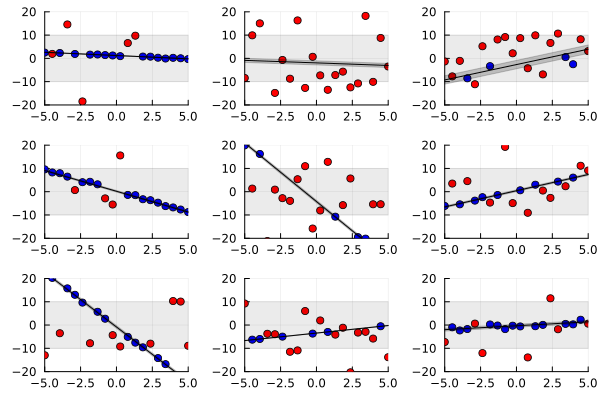

In [3]:
# Generate nine traces and visualize them
function visualize_trace(trace; title="")
    (((linear_model, noise, outlier_flags), ys), xs) = trace
    points = zip(xs, ys)

    outliers = [pt for (pt, outlier) in zip(points, outlier_flags) if outlier]
    inliers =  [pt for (pt, outlier) in zip(points, outlier_flags) if !outlier]
    Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing, xlims=[-5, 5], ylims=[-20, 20], title=title) 
    Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)

    inferred_line(x) = evaluate_model(linear_model, x)
    left_x = -5
    left_y  = inferred_line(left_x)
    right_x = 5
    right_y = inferred_line(right_x)
    Plots.plot!([left_x, right_x], [left_y, right_y], color="black", label=nothing)

    # Inlier noise
    inlier_std = noise
    noise_points = [(left_x, left_y + inlier_std),
                    (right_x, right_y + inlier_std),
                    (right_x, right_y - inlier_std),
                    (left_x, left_y - inlier_std)]
    Plots.plot!(Shape(map(first, noise_points), map(last, noise_points)), color="black", alpha=0.2, label=nothing)
    Plots.plot!(Shape([-5, 5, 5, -5], [10, 10, -10, -10]), color="black", label=nothing, alpha=0.08)
end

xs     = collect(range(-5, stop=5, length=20))
traces = [(simulate(regression_with_outliers(xs))[1], xs) for i in 1:9];
Plots.plot([visualize_trace(t) for t in traces]...)

##### Legend:

* red points: outliers;
* blue points: inliers (i.e. regular data);
* dark grey shading: noise associated with inliers; and
* light grey shading: noise associated with outliers.

Note that an outlier can occur anywhere — including close to the line — and
that our model is capable of generating datasets in which the vast majority
of points are outliers.

## 3. The problem with generic importance sampling  <a name="generic-importance"></a>

To motivate the need for more complex inference algorithms, let's begin by
using the simple importance sampling method from the previous tutorial, and
thinking about where it fails.

First, let us create a synthetic dataset to do inference _about_.

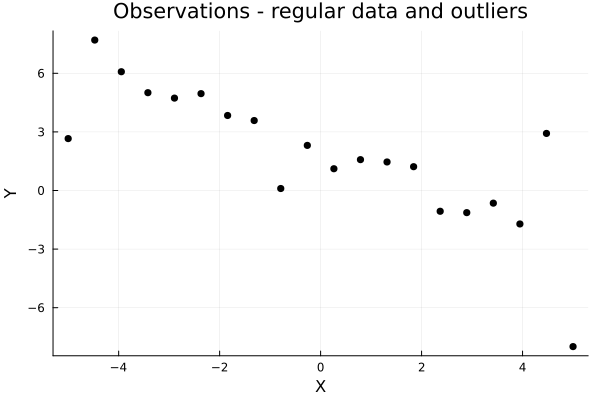

In [4]:
function make_synthetic_dataset(n)
    Random.seed!(1)
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope = -1
    true_intercept = 2
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            y = true_slope * x + true_intercept + randn() * true_inlier_noise
        end
        push!(ys, y)
    end
    (xs, ys)
end
    
(xs, ys) = make_synthetic_dataset(20);
Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

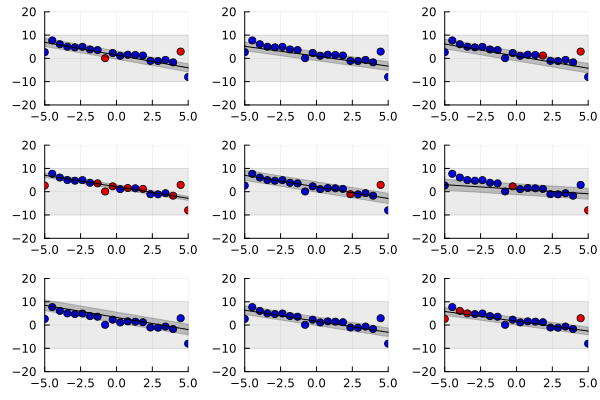

In [5]:
# Would something like this work? Or would the unsampling introduce unnecessary variance?
# proposal(y) = @prob begin
#     (linear_model, noise, outliers), ys <<= regression_with_outliers
#     n = length(y)
#     ys >>= iid(normal(0, 1), n)
# end

proposal(y) = @prob begin
    linear_model <<= linear_model_prior
    noise <<= gamma(1, 1)
    n = length(xs)
    prob_outlier <<= uniform(0, 1)
    outliers <<= iid(bernoulli(prob_outlier), n)
    prob_outlier >>= beta(1 + sum(outliers), n - sum(outliers) + 1)
    return linear_model, noise, outliers
end

_, _, basis = simulate(regression_with_outliers(xs))
traces  = [((Pun.importance_resampling(regression_with_outliers(xs), proposal, ys, basis, 2000), ys), xs ) for i in 1:9]
Plots.plot([visualize_trace(t) for t in traces]...)

We see here that importance resampling hasn't completely failed: it generally
finds a reasonable position for the line. But the details are off: there is
little logic to the outlier classification, and the inferred noise around the
line is too wide. The problem is that there are just too many variables to
get right, and so sampling everything in one go is highly unlikely to produce
a perfect hit.

In the remainder of this notebook, we'll explore techniques for finding the
right solution _iteratively_, beginning with an initial guess and making many
small changes, until we achieve a reasonable posterior sample.

## 4. MCMC Inference Part 1: Block Resimulation  <a name="mcmc-1"></a>

### What is MCMC?

_Markov Chain Monte Carlo_ ("MCMC") methods are a powerful family of
algorithms for iteratively producing approximate samples from a distribution
(when applied to Bayesian inference problems, the posterior distribution of
unknown (hidden) model variables given data).

There is a rich theory behind MCMC methods, but we focus on applying MCMC in
Gen and introducing theoretical ideas only when necessary for understanding.
As we will see, Gen provides abstractions that hide and automate much of the
math necessary for implementing MCMC algorithms correctly.

The general shape of an MCMC algorithm is as follows. We begin by sampling an
intial setting of all unobserved variables; in Gen, we produce an initial
_trace_ consistent with (but not necessarily _probable_ given) our
observations. Then, in a long-running loop, we make small, stochastic changes
to the trace; in order for the algorithm to be asymptotically correct, these
stochastic updates must satisfy certain probabilistic properties.

One common way of ensuring that the updates do satisfy those properties is to
compute a _Metropolis-Hastings acceptance ratio_. Essentially, after
proposing a change to a trace, we add an "accept or reject" step that
stochastically decides whether to commit the update or to revert it. This is
an over-simplification, but generally speaking, this step ensures we are more
likely to accept changes that make our trace fit the observed data better,
and to reject ones that make our current trace worse. The algorithm also
tries not to go down dead ends: it is more likely to take an exploratory step
into a low-probability region if it knows it can easily get back to where it
came from.

Gen's `metropolis_hastings` function _automatically_ adds this
"accept/reject" check (including the correct computation of the probability
of acceptance or rejection), so that inference programmers need only
think about what sorts of updates might be useful to propose. Starting in
this section, we'll look at several design patterns for MCMC updates, and how
to apply them in Gen.

### Block Resimulation

One of the simplest strategies we can use is called Resimulation MH, and it
works as follows.

We begin, as in most iterative inference algorithms, by sampling an initial
trace from our model, fixing the observed choices to their observed values.

```julia
# Gen's `generate` function accepts a model, a tuple of arguments to the model,
# and a `ChoiceMap` representing observations (or constraints to satisfy). It returns
# a complete trace consistent with the observations, and an importance weight.  
# In this call, we ignore the weight returned.
(tr, _) = generate(regression_with_outliers, (xs,), observations)
```

Then, in each iteration of our program, we propose changes to all our model's
variables in "blocks," by erasing a set of variables from our current trace
and _resimulating_ them from the model. After resimulating each block of
choices, we perform an accept/reject step, deciding whether the proposed
changes are worth making.

```julia
# Pseudocode
for iter=1:500
    tr = maybe_update_block_1(tr)
    tr = maybe_update_block_2(tr)
    ...
    tr = maybe_update_block_n(tr)
end
```

The main design choice in designing a Block Resimulation MH algorithm is how
to block the choices together for resimulation. At one extreme, we could put
each random choice the model makes in its own block. At the other, we could
put all variables into a single block (a strategy sometimes called
"independent" MH, and which bears a strong similarity to importance
resampling, as it involves repeatedly generating completely new traces and
deciding whether to keep them or not). Usually, the right thing to do is
somewhere in between.

For the regression problem, here is one possible blocking of choices:

**Block 1: `slope`, `intercept`, and `noise`.** These parameters determine
the linear relationship; resimulating them is like picking a new line. We
know from our importance sampling experiment above that before too long,
we're bound to sample something close to the right line.

**Blocks 2 through N+1: Each `is_outlier`, in its own block.** One problem we
saw with importance sampling in this problem was that it tried to sample
_every_ outlier classification at once, when in reality the chances of a
single sample that correctly classifies all the points are very low. Here, we
can choose to resimulate each `is_outlier` choice separately, and for each
one, decide whether to use the resimulated value or not.

**Block N+2: `prob_outlier`.** Finally, we can propose a new `prob_outlier`
value; in general, we can expect to accept the proposal when it is in line 
with the current hypothesized proportion of `is_outlier` choices that are 
set to `true`.

Resimulating a block of variables is the simplest form of update that Gen's
`metropolis_hastings` operator (or `mh` for short) supports. When supplied
with a _current trace_ and a _selection_ of trace addresses to resimulate,
`mh` performs the resimulation and the appropriate accept/reject check, then
returns a possibly updated trace, along with a boolean indicating whether the 
update was accepted or not. A selection is created using the `select`
method. So a single update of the scheme we proposed above would look like
this:

In [6]:
sample_outlier = @prob begin
    prob_outlier <<= uniform(0, 1)
    outlier <<= bernoulli(prob_outlier)
    prob_outlier >>= outlier ? beta(2, 1) : beta(1, 2)
    return outlier
end

# Perform a single block resimulation update of a trace.
# NOTE: we have to hardcode the proposals here instead of nicely extracting them from the model itself
function block_resimulation_update(model, params, w, basis)
    
    # Block 1: Update the line's parameters
    block_1_proposal(((linear_model, noise, outliers), ys)) = @prob begin
        new_linear_model <<= linear_model_prior
        new_noise <<= gamma(1, 1)
        new_outliers .<<= outliers
        new_ys .<<= ys
        return (new_linear_model, new_noise, new_outliers), new_ys
    end
    params, w, basis = Pun.mh(model, block_1_proposal, params, w, basis)
    
    # Blocks 2-N+1: Update the outlier classifications
    n = length(xs)
    block_2_proposal(i) = (params) -> @prob begin
        (linear_model, noise, outliers), ys = params
        new_linear_model .<<= linear_model
        new_noise .<<= noise
        new_outliers <<= mapM(j -> j == i ? sample_outlier : dirac(outliers[j]), 1:n)
        new_ys .<<= ys
        return (new_linear_model, new_noise, new_outliers), new_ys
    end
    for i=1:n
        params, w, basis = Pun.mh(model, block_2_proposal(i), params, w, basis)
    end
    
    # Return the updated trace
    return params, w, basis
end;

All that's left is to (a) obtain an initial trace, and then (b) run that
update in a loop for as long as we'd like:

In [7]:
function block_resimulation_inference(xs, ys)
    # Sample starting value from prior
    (latents, _), w, basis = simulate(regression_with_outliers(xs))
    # simulate returns 1/density estimate, so for initial density estimate, we invert
    w = -w
    # Note that we *observe* ys, so we need to make sure that params has correct value set
    params = (latents, ys)
    
    for iter=1:500
        params, w, basis = block_resimulation_update(regression_with_outliers(xs), params, w, basis)
    end
    return params, w
end;

Let's test it out:

In [13]:
using LogExpFunctions

In [8]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time params, score = block_resimulation_inference(xs, ys)
    scores[i] = score
end
println("Log probability: ", logsumexp(scores) - log(length(scores)))

 12.507574 seconds (202.16 M allocations: 8.410 GiB, 5.94% gc time, 7.22% compilation time)
 11.345551 seconds (200.33 M allocations: 8.320 GiB, 6.35% gc time)
 11.448872 seconds (202.62 M allocations: 8.477 GiB, 6.30% gc time, 0.78% compilation time)
 11.385875 seconds (202.57 M allocations: 8.493 GiB, 6.38% gc time)
 11.392201 seconds (201.73 M allocations: 8.412 GiB, 6.35% gc time)
 11.386792 seconds (202.45 M allocations: 8.467 GiB, 6.42% gc time)
 11.447894 seconds (201.45 M allocations: 8.407 GiB, 6.41% gc time)
 11.379140 seconds (202.57 M allocations: 8.477 GiB, 6.46% gc time)
 11.360645 seconds (201.13 M allocations: 8.382 GiB, 6.43% gc time)
 11.399451 seconds (201.61 M allocations: 8.419 GiB, 6.49% gc time)


UndefVarError: UndefVarError: `logsumexp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing LogExpFunctions in the current active module Main
Hint: a global variable of this name may be made accessible by importing StatsFuns in the current active module Main

It's one thing to see a log probability increase; it's better to understand
what the inference algorithm is actually doing, and to see _why_ it's doing
better.

A great tool for debugging and improving MCMC algorithms is visualization. We
can use `Plots.@animate` to produce an
animated visualization:

Plots.AnimatedGif("/var/folders/rn/jqrwv4s94353h34h4r7t__sm0000gn/T/jl_uPMJcjezG5.gif")
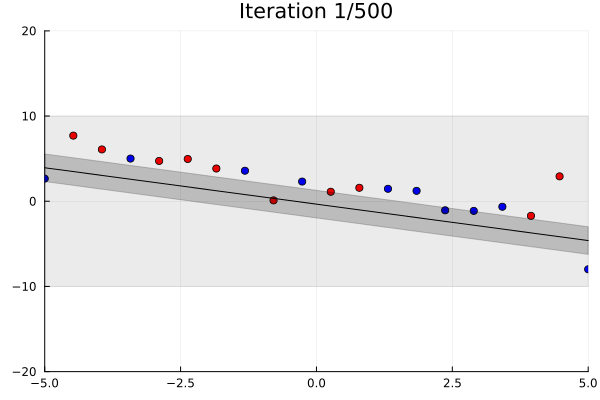

In [14]:
(latents, _), w, basis = simulate(regression_with_outliers(xs))
# simulate returns 1/density estimate, so for initial density estimate, we invert
w = -w
params = (latents, ys)

viz = Plots.@animate for i in 1:500
    global params, w, basis
    params, w, basis = block_resimulation_update(regression_with_outliers(xs), params, w, basis)
    visualize_trace((params, xs); title="Iteration $i/500")
end;
gif(viz)

We can see that although the algorithm keeps changing the inferences of which points are inliers and outliers, 
it has a harder time refining the continuous parameters. We address this challenge next.

## 5. MCMC Inference Part 2: Gaussian Drift MH  <a name="mcmc-2"></a>

So far, we've seen one form of incremental trace update:

```julia
(tr, did_accept) = mh(tr, select(:address1, :address2, ...))
```

This update is incremental in that it only proposes changes to part of a
trace (the selected addresses). But when computing _what_ changes to propose,
it ignores the current state completely and resimulates all-new values from
the model.

That wholesale resimulation of values is often not the best way to search for
improvements. To that end, Gen also offers a more general flavor of MH:

```julia
(tr, did_accept) = mh(tr, custom_proposal, custom_proposal_args)
```

A "custom proposal" is just what it sounds like: whereas before, we were
using the _default resimulation proposal_ to come up with new values for the
selected addresses, we can now pass in a generative function that samples
proposed values however it wants.

For example, here is a custom proposal that takes in a current trace, and
proposes a new slope and intercept by randomly perturbing the existing
values:

In [10]:
line_proposal(current_model::LinearModel) = @prob begin
    slope <<= normal(current_model.slope, 0.5)
    intercept <<= normal(current_model.intercept, 0.5)
    return LinearModel(slope, intercept)
end;

This is often called a "Gaussian drift" proposal, because it essentially amounts to proposing steps of a random walk. (What makes it different from a random walk is that we will still use an MH accept/reject step to make sure we don't wander into areas of very low probability.)

To use the proposal, we write:

```julia
(tr, did_accept) = mh(tr, line_proposal, ())
```

Two things to note:

1. We no longer need to pass a selection of addresses. Instead, Gen assumes
   that whichever addresses are sampled by the proposal (in this case,
   `:slope` and `:intercept`) are being proposed to.

2. The argument list to the proposal is an empty tuple, `()`. The
   `line_proposal` generative function does expect an argument, the previous
   trace, but this is supplied automatically to all MH custom proposals
   (a proposal generative function for use with `mh` must take as its first argument the 
   current trace of the model).

Let's swap it into our update:

In [11]:
function gaussian_drift_update(model, params, w, basis)
    
    # Gaussian proposal for line parameters
    block_1_proposal(((linear_model, noise, outliers), ys)) = @prob begin
        new_linear_model <<= line_proposal(linear_model)
        new_noise .<<= noise
        new_outliers .<<= outliers
        new_ys .<<= ys
        return (new_linear_model, new_noise, new_outliers), new_ys
    end
    params, w, basis = Pun.mh(model, block_1_proposal, params, w, basis)
    
    # Blocks 2-N+1: Update the outlier classifications
    n = length(xs)
    block_2_proposal(i) = (params) -> @prob begin
        (linear_model, noise, outliers), ys = params
        new_linear_model .<<= linear_model
        new_noise .<<= noise
        new_outliers <<= mapM(j -> j == i ? sample_outlier : dirac(outliers[j]), 1:n)
        new_ys .<<= ys
        return (new_linear_model, new_noise, new_outliers), new_ys
    end
    for i=1:n
        params, w, basis = Pun.mh(model, block_2_proposal(i), params, w, basis)
    end

    # Finally update noise
    noise_proposal(((linear_model, noise, outliers), ys)) = @prob begin
        new_linear_model .<<= linear_model
        new_noise <<= gamma(1, 1)
        new_outliers .<<= outliers
        new_ys .<<= ys
        return (new_linear_model, new_noise, new_outliers), new_ys
    end
    params, w, basis = Pun.mh(model, noise_proposal, params, w, basis)
    
    # Return the updated trace
    return params, w, basis
end;

If we compare the Gaussian Drift proposal visually with our old algorithm, we
can see the new behavior:

Plots.AnimatedGif("/var/folders/rn/jqrwv4s94353h34h4r7t__sm0000gn/T/jl_85Up6hWbOB.gif")
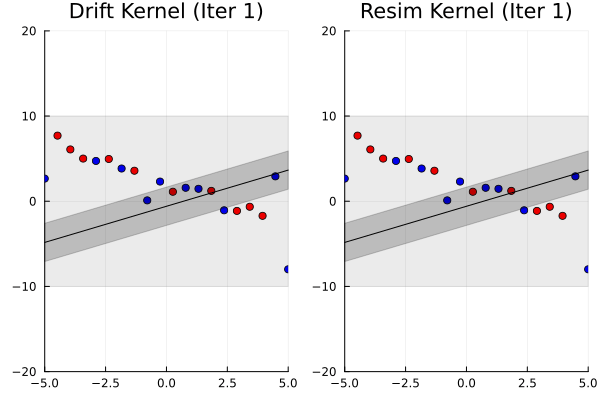

In [17]:
(latents, _), w, basis = simulate(regression_with_outliers(xs))
# simulate returns 1/density estimate, so for initial density estimate, we invert
w = -w
params1 = (latents, ys)
params2 = params1
w1, w2 = w, w

viz = Plots.@animate for i in 1:300
    global params1, params2, w1, w2, basis
    params1, w1, basis = gaussian_drift_update(regression_with_outliers(xs), params1, w1, basis)
    params2, w2, basis = block_resimulation_update(regression_with_outliers(xs), params2, w2, basis)
    Plots.plot(visualize_trace((params1, xs); title="Drift Kernel (Iter $i)"), 
               visualize_trace((params2, xs); title="Resim Kernel (Iter $i)"))
end;
gif(viz)

-----------

### Exercise: Analyzing the algorithms

Run the cell above several times. Compare the two
algorithms with respect to the following:

- How fast do they find a relatively good line?

- Does one of them tend to get stuck more than the other? Under what
  conditions? Why?

-----------

## 6. MCMC Inference Part 3: Heuristics to guide the process  <a name="mcmc-3"></a>

In this section, we'll look at another strategy for improving MCMC inference:
using arbitrary heuristics to make smarter proposals. In particular, we'll
use a method called "Random Sample Consensus" (or RANSAC) to quickly find
promising settings of the slope and intercept parameters.

RANSAC works as follows:
1. We repeatedly choose a small random subset of the points, say, of size 3.
2. We do least-squares linear regression to find a line of best fit for those
   points.
3. We count how many points (from the entire set) are near the line we found.
4. After a suitable number of iterations (say, 10), we return the line that
   had the highest score.

Here's our implementation of the algorithm in Julia:

In [59]:
import StatsBase

struct RANSACParams
    """the number of random subsets to try"""
    iters::Int

    """the number of points to use to construct a hypothesis"""
    subset_size::Int

    """the error threshold below which a datum is considered an inlier"""
    eps::Float64
    
    function RANSACParams(iters, subset_size, eps)
        if iters < 1
            error("iters < 1")
        end
        new(iters, subset_size, eps)
    end
end


function ransac(xs, ys, params::RANSACParams)
    best_num_inliers::Int = -1
    best_slope = NaN
    best_intercept = NaN
    for i=1:params.iters
        # select a random subset of points
        rand_ind = StatsBase.sample(1:length(xs), params.subset_size, replace=false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
        A = hcat(subset_xs, ones(length(subset_xs)))
        slope, intercept = A \ subset_ys # use backslash operator for least sq soln
        
        ypred = intercept .+ slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs.(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept)
end;

We can now wrap it in a Gen proposal that calls out to RANSAC, then samples a
slope and intercept near the one it proposed.

In [93]:
ransac_proposal(xs) = params -> @prob begin
    (linear_model, noise, outliers), ys = params
    (slope_guess, intercept_guess) = ransac(xs, real(ys), RANSACParams(10, 3, 1.))
    slope <<= normal(slope_guess, 0.1)
    intercept <<= normal(intercept_guess, 1.0)
    new_model .<<= LinearModel(slope, intercept)
    slope .>>= new_model.slope
    intercept .>>= new_model.intercept
    new_noise .<<= noise
    new_outliers .<<= outliers
    new_ys .<<= ys
    return (new_model, new_noise, new_outliers), new_ys
end;

(Notice that although `ransac` makes random choices, they are not addressed
(and they happen outside of a Gen generative function), so Gen cannot reason
about them. This is OK (see [1]). Writing proposals that have
traced internal randomness (i.e., that make traced random choices that are
not directly used in the proposal) can lead to better inference, but requires
the use of a more complex version of Gen's `mh` operator, which is beyond the
scope of this tutorial.)

[1] [Using probabilistic programs as
proposals](https://arxiv.org/abs/1801.03612), Marco F. Cusumano-Towner, Vikash K. Mansinghka, 2018.

One iteration of our update algorithm will now look like this:

In [133]:
n = length(xs)
outlier_proposal(i) = (params) -> @prob begin
    (linear_model, noise, outliers), ys = params
    new_linear_model .<<= linear_model
    new_noise .<<= noise
    new_outliers <<= mapM(j -> j == i ? sample_outlier : dirac(outliers[j]), 1:n)
    new_ys .<<= ys
    return (new_linear_model, new_noise, new_outliers), new_ys
end

noise_proposal(((linear_model, noise, outliers), ys)) = @prob begin
    new_linear_model .<<= linear_model
    new_noise <<= gamma(1, 1)
    new_outliers .<<= outliers
    new_ys .<<= ys
    return (new_linear_model, new_noise, new_outliers), new_ys
end

linear_model_proposal(((linear_model, noise, outliers), ys)) = @prob begin
    new_linear_model <<= line_proposal(linear_model)
    new_noise .<<= noise
    new_outliers .<<= outliers
    new_ys .<<= ys
    return (new_linear_model, new_noise, new_outliers), new_ys
end

function ransac_update(model, params, w, basis)
    # Use RANSAC to (potentially) jump to a better line
    # from wherever we are
    params, w, basis = Pun.mh(model, ransac_proposal(xs), params, w, basis)
    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        params, w, basis = Pun.mh(model, noise_proposal, params, w, basis)
        params, w, basis = Pun.mh(model, linear_model_proposal, params, w, basis)
        # Reclassify outliers
        for i=1:n
            params, w, basis = Pun.mh(model, outlier_proposal(i), params, w, basis)
        end
    end
    return params, w, basis
end

ransac_update (generic function with 1 method)

We can now run our main loop for just 5 iterations, and achieve pretty good
results. (Of course, since we do 20 inner loop iterations in `ransac_update`,
this is really closer to 100 iterations.) The running time is significantly
less than before, without a real dip in quality:

In [147]:
function ransac_initialization(xs, ys)
    # Initialize linear model with RANSAC, everything else from prior
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    ((model, noise, outliers), _), _, basis = simulate(regression_with_outliers(xs))
    params = ((LinearModel(slope, intercept), noise, outliers), ys)
    w = assess(regression_with_outliers(xs), params, basis)
    return params, w, basis
end

function ransac_inference(xs, ys)
    params, w, basis = ransac_initialization(xs, ys)
    for iter=1:5
        params, w, basis = ransac_update(regression_with_outliers(xs), params, w, basis)
    end
    return (params, xs), w
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr, score = ransac_inference(xs, ys)
    scores[i] = score
end
println("Log probability: ", logsumexp(scores) - log(length(scores)))

  2.827645 seconds (42.06 M allocations: 1.763 GiB, 15.06% gc time, 0.68% compilation time)
  2.461347 seconds (42.05 M allocations: 1.763 GiB, 5.19% gc time)
  2.502845 seconds (42.00 M allocations: 1.760 GiB, 4.86% gc time)
  2.431504 seconds (42.07 M allocations: 1.765 GiB, 4.88% gc time)
  2.366490 seconds (41.97 M allocations: 1.757 GiB, 4.69% gc time)
  2.402804 seconds (41.99 M allocations: 1.759 GiB, 4.63% gc time)
  2.367501 seconds (42.00 M allocations: 1.760 GiB, 4.73% gc time)
  2.363298 seconds (41.98 M allocations: 1.759 GiB, 4.57% gc time)
  2.443755 seconds (42.04 M allocations: 1.763 GiB, 4.60% gc time)
  2.342781 seconds (41.99 M allocations: 1.759 GiB, 4.75% gc time)
Log probability: -45.36025679351465


Let's visualize the algorithm:

Plots.AnimatedGif("/var/folders/rn/jqrwv4s94353h34h4r7t__sm0000gn/T/jl_upaPEVYRkL.gif")
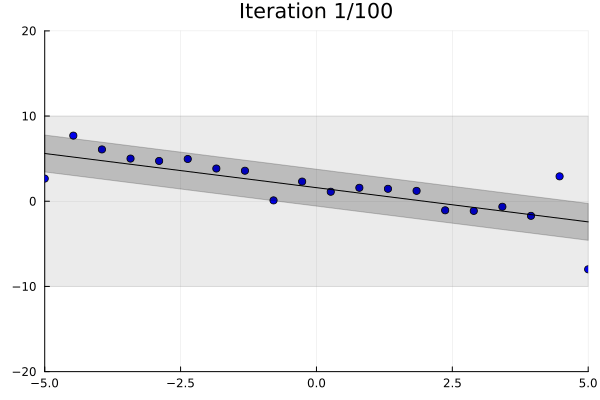

In [148]:
params, w, basis = ransac_initialization(xs, ys)
plots = []
for i in 1:100
    params, w, basis = ransac_update(regression_with_outliers(xs), params, w, basis)
    push!(plots, visualize_trace((params, xs); title="Iteration $i/100"))
end;
viz = Plots.animate(plots)
viz

-----------
### Exercise
#### Improving the heuristic
Currently, the RANSAC heuristic does not use the current trace's information
at all. Try changing it to use the current state as follows:
Instead of a constant `eps` parameter that controls whether a point is
considered an inlier, make this decision based on the currently hypothesized
noise level.  Specifically, set `eps` to be equal to the `noise` parameter of the trace.

Examine whether this improves inference (no need to respond in words here).

In [149]:
ransac_proposal_noise_based(xs) = params -> @prob begin
    (linear_model, noise, outliers), ys = params
    # We just change the RANSACParams to use `noise` for the `eps` value
    # Note that noise will be a dual number so we need to grab the `.value`
    (slope_guess, intercept_guess) = ransac(xs, real(ys), RANSACParams(10, 3, noise.value))
    slope <<= normal(slope_guess, 0.1)
    intercept <<= normal(intercept_guess, 1.0)
    new_model .<<= LinearModel(slope, intercept)
    slope .>>= new_model.slope
    intercept .>>= new_model.intercept
    new_noise .<<= noise
    new_outliers .<<= outliers
    new_ys .<<= ys
    return (new_model, new_noise, new_outliers), new_ys
end;

<!-- # BEGIN ANSWER KEY
@gen function ransac_proposal_noise_based(prev_trace, xs, ys)
    eps = prev_trace[:noise]
    params = RANSACParams(10, 3, eps)
    (slope_guess, intercept_guess) = ransac(xs, ys, params)
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
    return params, slope, intercept # (return values just for testing)
end;
# END ANSWER KEY -->
<hr>

The code below runs the RANSAC inference as above, but using `ransac_proposal_noise_based`.

In [150]:
function ransac_update_noise_based(model, params, w, basis)
    # Use RANSAC to (potentially) jump to a better line
    params, w, basis = Pun.mh(model, ransac_proposal_noise_based(xs), params, w, basis)
    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        params, w, basis = Pun.mh(model, noise_proposal, params, w, basis)
        params, w, basis = Pun.mh(model, linear_model_proposal, params, w, basis)
        # Reclassify outliers
        for i=1:n
            params, w, basis = Pun.mh(model, outlier_proposal(i), params, w, basis)
        end
    end
    return params, w, basis
end
function ransac_inference_noise_based(xs, ys)
    params, w, basis = ransac_initialization(xs, ys)
    for iter=1:5
        params, w, basis = ransac_update_noise_based(regression_with_outliers(xs), params, w, basis)
    end
    return (params, xs), w
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr, score = ransac_inference_noise_based(xs, ys)
    scores[i] = score
end
println("Log probability: ", logsumexp(scores) - log(length(scores)))

  2.560320 seconds (42.31 M allocations: 1.774 GiB, 4.55% gc time, 5.72% compilation time)
  2.362059 seconds (41.98 M allocations: 1.758 GiB, 4.70% gc time)
  2.360919 seconds (41.98 M allocations: 1.758 GiB, 4.71% gc time)
  2.357347 seconds (42.00 M allocations: 1.760 GiB, 4.56% gc time)
  2.352968 seconds (41.99 M allocations: 1.759 GiB, 4.73% gc time)
  2.346421 seconds (41.98 M allocations: 1.759 GiB, 4.58% gc time)
  2.408360 seconds (42.03 M allocations: 1.762 GiB, 4.63% gc time)
  2.455235 seconds (41.99 M allocations: 1.759 GiB, 4.54% gc time)
  2.382076 seconds (41.98 M allocations: 1.758 GiB, 4.73% gc time)
  2.512478 seconds (41.99 M allocations: 1.759 GiB, 4.32% gc time)
Log probability: -44.45265410740286


<!-- # BEGIN ANSWER KEY 2B.2

@gen function inlier_heuristic_proposal(prev_trace, xs, ys)
    # get_indeces for inliers.
    inlier_indeces = filter(
        i -> !prev_trace[:data => i => :is_outlier], 
        1:length(xs)
    )
    xs_inlier = xs[inlier_indeces]
    ys_inlier = ys[inlier_indeces]
    # estimate slope and intercept using least squares.
    A = hcat(xs_inlier, ones(length(xs_inlier)))
    inlier_slope, inlier_intercept = A \ ys_inlier
    
    # Make a noisy proposal.
    slope     ~ normal(inlier_slope, 0.5)
    intercept ~ normal(inlier_intercept, 0.5)
    # We return values here for testing; normally, proposals don't have to return values.
    return inlier_slope, inlier_intercept
end;

function inlier_heuristic_update(tr)
    # Use inlier heuristics to (potentially) jump to a better line
    # from wherever we are.
    (tr, _) = mh(tr, inlier_heuristic_proposal, (xs, ys))    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end;

# END ANSWER KEY -->
----

### Exercise: Initialization

In our inference program above, when generating an initial trace on which to
iterate, we initialize the slope and intercept to values proposed by RANSAC.
If we don't do this, the performance decreases sharply, despite the fact that
we still propose new slope/intercept pairs from RANSAC once the loop starts.
Why is this?

----

## 7. MAP Optimization  <a name="map"></a>

Everything we've done so far has been within the MCMC framework. But
sometimes you're not interested in getting posterior samples—sometimes you
just want a single likely explanation for your data. Gen also provides tools
for _maximum a posteriori_ estimation ("MAP estimation"), the problem of
finding a trace that maximizes the posterior probability under the model
given observations.

For example, let's say we wanted to take a trace and assign each point's
`is_outlier` score to the most likely possibility. We can do this by
iterating over both possible traces, scoring them, and choosing the one with
the higher score. We can do this using Gen's
[`update`](https://www.gen.dev/docs/stable/ref/gfi/#Update-1) function,
which allows us to manually update a trace to satisfy some constraints:

In [42]:
function is_outlier_map_update(tr)
    (xs,) = get_args(tr)
    for i=1:length(xs)
        constraints = choicemap(:prob_outlier => 0.1)
        constraints[:data => i => :is_outlier] = false
        (trace1,) = update(tr, (xs,), (NoChange(),), constraints)
        constraints[:data => i => :is_outlier] = true
        (trace2,) = update(tr, (xs,), (NoChange(),), constraints)
        tr = (get_score(trace1) > get_score(trace2)) ? trace1 : trace2
    end
    tr
end;

For continuous parameters, we can use Gen's `map_optimize` function, which uses _automatic differentiation_ to shift the selected parameters in the direction that causes the probability of the trace to increase most sharply:

```julia
tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
```

Putting these updates together, we can write an inference program that uses our RANSAC algorithm from above to get an initial trace, then tunes it using optimization:

Score after ransac: -53.16512889890808. Final score: -41.01265556385335.


Plots.AnimatedGif("/Users/alexlew/gen-quickstart/tutorials/tmp.gif")
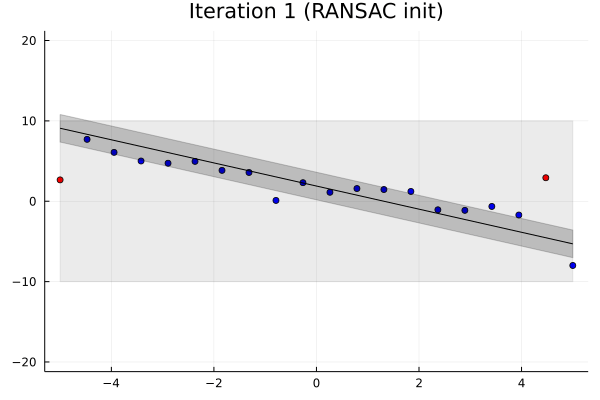

In [63]:
using StatsBase: mean

(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))


ransac_score, final_score = 0, 0
viz = Plots.@animate for i in 1:35
    global tr, ransac_score
    if i < 6
        tr = ransac_update(tr)
    else
        tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr = map_optimize(tr, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        tr = is_outlier_map_update(tr)
        optimal_prob_outlier = mean([tr[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr, = update(tr, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))
    end
    
    if i == 5
        ransac_score = get_score(tr)
    end
    
    visualize_trace(tr; title="Iteration $i $(i < 6 ? "(RANSAC init)" : "(MAP optimization)")")
end
final_score = get_score(tr)

println("Score after ransac: $(ransac_score). Final score: $(final_score).")
gif(viz)

Below, we evaluate the algorithm and we see that it gets our best scores yet, which is what it's meant to do:

In [44]:
function map_inference(xs, ys, observations)
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update(tr)
    end
    
    for iter = 1:20
        # Take a single gradient step on the line parameters.
        tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr = map_optimize(tr, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        
        # Choose the most likely classification of outliers.
        tr = is_outlier_map_update(tr)
        
        # Update the prob outlier
        choices = get_choices(tr)
        optimal_prob_outlier = count(i -> choices[:data => i => :is_outlier], 1:length(xs)) / length(xs)
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        (tr, _) = update(tr, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))        
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = map_inference(xs,ys,observations)
    scores[i] = get_score(tr)
end
println(logmeanexp(scores))

  0.306594 seconds (4.43 M allocations: 259.922 MiB, 22.56% gc time, 31.70% compilation time)
  0.201518 seconds (4.17 M allocations: 244.969 MiB, 16.03% gc time)
  0.190371 seconds (4.16 M allocations: 244.396 MiB, 10.77% gc time)
  0.200117 seconds (4.15 M allocations: 244.203 MiB, 15.65% gc time)
  0.203404 seconds (4.17 M allocations: 244.969 MiB, 15.95% gc time)
  0.198736 seconds (4.17 M allocations: 244.968 MiB, 15.39% gc time)
  0.201941 seconds (4.16 M allocations: 244.777 MiB, 15.56% gc time)
  0.198005 seconds (4.17 M allocations: 245.065 MiB, 15.73% gc time)
  0.196482 seconds (4.17 M allocations: 245.065 MiB, 15.46% gc time)
  0.190100 seconds (4.16 M allocations: 244.585 MiB, 15.34% gc time)
-41.01266149777553


This doesn't necessarily mean that it's "better," though. It finds the most
probable explanation of the data, which is a different problem from the one
we tackled with MCMC inference. There, the goal was to sample from the
posterior, which allows us to better characterize our uncertainty. Using
MCMC, there might be a borderline point that is sometimes classified as an
outlier and sometimes not, reflecting our uncertainty; with MAP optimization,
we will always be shown the most probable answer.

---------

Below we generate a dataset for which there are two distinct possible explanations
(the grey lines) under our model `regression_with_outliers`. 

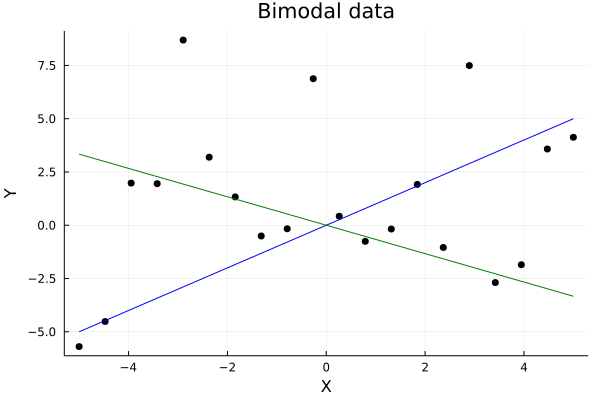

In [45]:
function make_bimodal_dataset(n)
    Random.seed!(4) 
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope1 = 1
    true_intercept1 = 0
    true_slope2 = -2/3
    true_intercept2 = 0
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            if rand((true,false))
                y = true_slope1 * x + true_intercept1 + randn() * true_inlier_noise
            else
                y = true_slope2 * x + true_intercept2 + randn() * true_inlier_noise
            end
        end
        push!(ys, y)
    end
    xs,ys,true_slope1,true_slope2,true_intercept1,true_intercept2
end;

(xs, ys_bimodal, m1,m2,b1,b2) = make_bimodal_dataset(20);
observations_bimodal = make_constraints(ys_bimodal);

Plots.scatter(xs, ys_bimodal, color="black", xlabel="X", ylabel="Y", label=nothing, title="Bimodal data")
Plots.plot!(xs,m1.*xs.+b1, color="blue", label=nothing)
Plots.plot!(xs,m2.*xs.+b2, color="green", label=nothing)

### Exercise

For this dataset, the code below will run (i) Metropolis hastings with a
Gaussian Drift proposal and (ii) MAP optimization, using implementations from
above. Make sure you understand what it is doing. Do both algorithms explore
both modes (i.e. both possible explanations)?  Play with running the
algorithms multiple times.  

If one or both algorithms doesn't then explain in a few sentences why you
think this is.


i.   MH Gaussian drift score -67.90298781592773
ii.  MAP final score: -41.012655584900045.


Plots.AnimatedGif("/Users/alexlew/gen-quickstart/tutorials/tmp.gif")
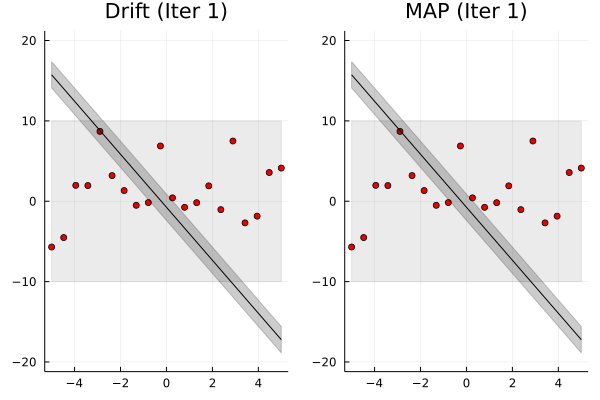

In [51]:
(slope, intercept) = ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(
    regression_with_outliers, (xs,), 
    merge(observations_bimodal, slope_intercept_init))

tr_drift = tr
tr_map   = tr

viz = Plots.@animate for i in 1:305
    global tr_map, tr_drift
    if i < 6
        tr_drift = ransac_update(tr)
        tr_map   = tr_drift
    else
        # Take a single gradient step on the line parameters.
        tr_map = map_optimize(tr_map, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr_map = map_optimize(tr_map, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        # Choose the most likely classification of outliers.
        tr_map = is_outlier_map_update(tr_map)
        # Update the prob outlier
        optimal_prob_outlier = mean([tr_map[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr_map, = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))
    
        # Gaussian drift update:
        tr_drift = gaussian_drift_update(tr_drift)
    end
    
    Plots.plot(visualize_trace(tr_drift; title="Drift (Iter $i)"), visualize_trace(tr_map; title="MAP (Iter $i)"))
end

drift_final_score = get_score(tr_drift)
map_final_score = get_score(tr_map)
println("i.   MH Gaussian drift score $(drift_final_score)")
println("ii.  MAP final score: $(final_score).")

gif(viz)

The above was good for an overall qualitative examination, but let's also 
examine a little more quantitatively how often the two proposals explore
the two modes, by running multiple times and keeping track of how often the
slope is positive/negative for each, for a few different initializations.

**Warning: the following cell may take a few minutes to run.**

In [49]:
total_runs = 25;

In [48]:
for (index, value) in enumerate([(1, 0), (-1, 0), ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))])
    n_pos_drift = n_neg_drift = n_pos_map = n_neg_map = 0
    
    for i=1:total_runs
        pos_drift = neg_drift = pos_map = neg_map = false

        #### RANSAC for initializing
        (slope, intercept) = value # ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
        slope_intercept_init = choicemap()
        slope_intercept_init[:slope] = slope
        slope_intercept_init[:intercept] = intercept
        (tr,) = generate(
            regression_with_outliers, (xs,), 
            merge(observations_bimodal, slope_intercept_init))
        for iter=1:5
            tr = ransac_update(tr)
        end
        ransac_score = get_score(tr)
        tr_drift = tr # version of the trace for the Gaussian drift algorithm
        tr_map = tr   # version of the trace for the MAP optimization

        #### Refine the parameters according to each of the algorithms
        for iter = 1:300
            # MAP optimiztion:
            # Take a single gradient step on the line parameters.
            tr_map = map_optimize(tr_map, select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
            tr_map = map_optimize(tr_map, select(:noise), max_step_size=1e-2, min_step_size=1e-5)
            # Choose the most likely classification of outliers.
            tr_map = is_outlier_map_update(tr_map)
            # Update the prob outlier
            optimal_prob_outlier = count(i -> tr_map[:data => i => :is_outlier], 1:length(xs)) / length(xs)
            optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
            (tr_map, _) = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))

            # Gaussian drift update:
            tr_drift = gaussian_drift_update(tr_drift)

            if tr_drift[:slope] > 0
                pos_drift = true
            elseif tr_drift[:slope] < 0
                neg_drift = true
            end
            if tr_map[:slope] > 0
                pos_map = true  
            elseif tr_map[:slope] < 0
                neg_map = true
            end
        end

        if pos_drift
            n_pos_drift += 1
        end
        if neg_drift
            n_neg_drift += 1
        end
        if pos_map
            n_pos_map += 1
        end
        if neg_map
            n_neg_map += 1
        end
    end
    (slope, intercept) = value
    println("\n\nWITH INITIAL SLOPE $(slope) AND INTERCEPT $(intercept)")
    println("TOTAL RUNS EACH: $(total_runs)")
    println("\n       times neg. slope    times pos. slope")
    println("\ndrift: $(n_neg_drift)                  $(n_pos_drift)")
    println("\nMAP:   $(n_neg_map)                    $(n_pos_map)")
end



WITH INITIAL SLOPE 1 AND INTERCEPT 0
TOTAL RUNS EACH: 25

       times neg. slope    times pos. slope

drift: 25                  20

MAP:   14                    15


WITH INITIAL SLOPE -1 AND INTERCEPT 0
TOTAL RUNS EACH: 25

       times neg. slope    times pos. slope

drift: 25                  13

MAP:   17                    9


WITH INITIAL SLOPE -0.6257688854452014 AND INTERCEPT -0.3262071756432166
TOTAL RUNS EACH: 25

       times neg. slope    times pos. slope

drift: 25                  12

MAP:   19                    7


Although this experiment is imperfect, we can broadly see that the drift kernel often explores both modes within a single run, whereas this is rarer for the MAP kernel (in 25 runs, the MAP kernel visits on average 1.08 of the 2 modes, whereas the drift kernel visits 1.6).